In [104]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops
from skimage import io
import geopandas as gpd
from arcgis.learn import ScannedMapDigitizer


torch not available

No module named 'fastai.basic_train'


In [61]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]

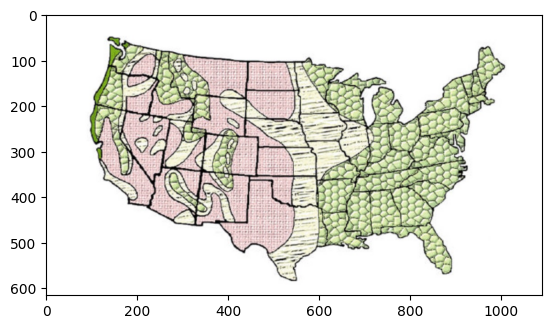

In [62]:
usa = cv2.imread('map_image.jpg')
usa =cv2.cvtColor(usa, cv2.COLOR_BGR2RGB)
plt.imshow(usa)
plt.show()

In [63]:
vectorized = usa.reshape((-1,3))
vectorized = np.float32(vectorized)

In [64]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [65]:
k = 5
attempts = 10
ret, label, center = cv2.kmeans(vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

In [66]:
center = np.uint8(center)

In [67]:
res = center[label.flatten()]
result_image = res.reshape((usa.shape))

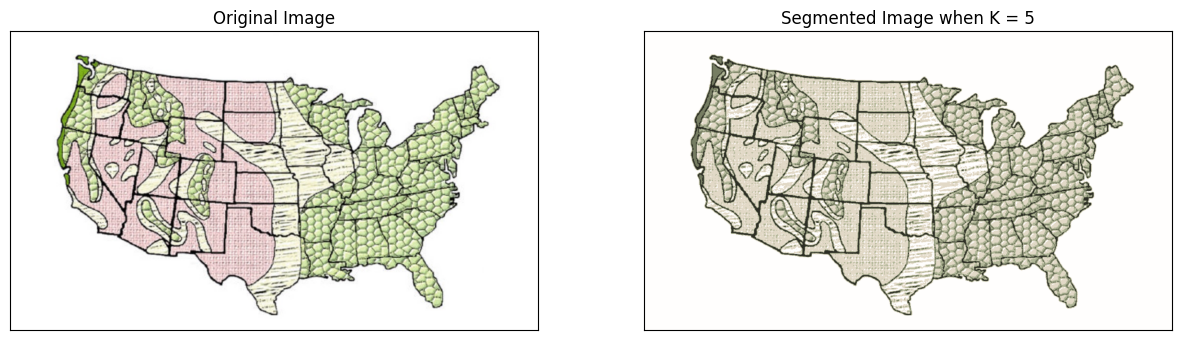

In [68]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(usa)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % k), plt.xticks([]), plt.yticks([])
plt.show()


In [69]:
#restart
usa = cv2.imread('map_image.jpg')
gray  =cv2.cvtColor(usa, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(gray, 30, 200)
cv2.imshow('canny edges', edged)
cv2.waitKey(0)

-1

In [88]:
lab_image = cv2.cvtColor(usa, cv2.COLOR_BGR2LAB)
pixels = lab_image.reshape((-1, 3))
pixels = np.float32(pixels)
num_clusters = 4
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixels, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(usa.shape)
cv2.imshow('Segmented Image', segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [89]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.imshow('canny edges after contouring', edged)
cv2.waitKey(0)

-1

In [71]:
print('Numbers of contours found=' + str(len(contours)))

Numbers of contours found=71


In [72]:
cv2.drawContours(usa,contours,-1,(0,255,0),3)
cv2.imshow('contours',usa)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [90]:
kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]], dtype=np.float32)
contrast = cv2.filter2D(gray, -1, kernel)

In [91]:
contrast = cv2.normalize(contrast, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# energy = greycoprops(glcm, 'energy')
# entropy = greycoprops(glcm, 'entropy')

In [92]:
threshold_value = 5  # Adjust this threshold as needed
shading_mask = np.where(contrast > threshold_value, 255, 0).astype(np.uint8)

In [93]:
segmented_image = cv2.bitwise_and(usa, usa, mask=shading_mask)
cv2.imshow('Segmented Image', segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [99]:
# Calculate texture features (e.g., contrast) using GLCM
distances = [1]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm = greycomatrix(gray, distances=distances, angles=angles, levels=256)

# Calculate contrast
contrast = greycoprops(glcm, 'contrast')

# Apply a threshold to segment regions based on contrast values
threshold_value = 100  # Adjust as needed
binary_mask = (contrast > threshold_value).astype(np.uint8)
_, labeled_mask = cv2.connectedComponents(binary_mask)

roi_properties = []
for label in range(1, labeled_mask.max() + 1):
    roi_mask = np.where(labeled_mask == label, 255, 0).astype(np.uint8)
    contour, _ = cv2.findContours(roi_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contour:
        contour = contour[0]  # Take the first contour
        # Extract relevant properties, e.g., centroid coordinates
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            roi_properties.append({'label': label, 'centroid_x': cX, 'centroid_y': cY})
gdf = gpd.GeoDataFrame(roi_properties, geometry=gpd.points_from_xy([prop['centroid_x'] for prop in roi_properties],
                                                                  [prop['centroid_y'] for prop in roi_properties]))

c:\Users\lukes\anaconda3\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


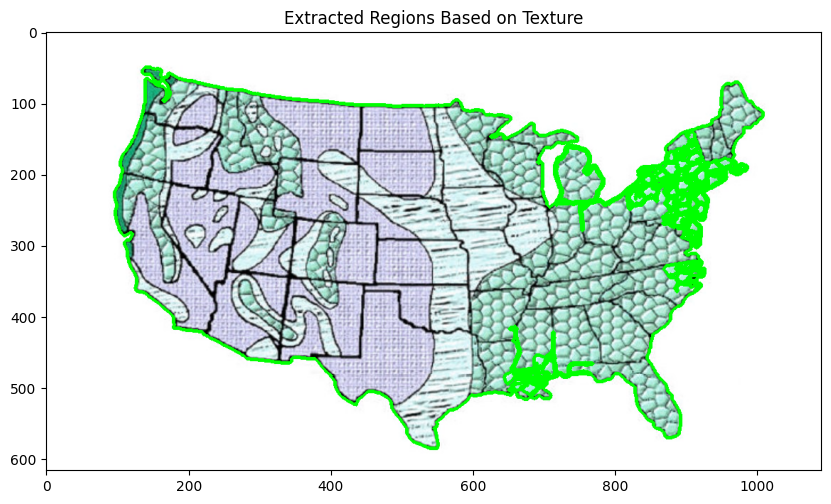

In [100]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(usa, cmap='gray')
gdf.plot(ax=ax, color='red', markersize=10)
plt.title('Extracted Regions Based on Texture')
plt.show()

In [103]:
color_hist = cv2.calcHist([lab_image], [1, 2], None, [32, 32], [0, 256, 0, 256])

gray_image = cv2.cvtColor(usa, cv2.COLOR_BGR2GRAY)
glcm = greycomatrix(gray_image, distances=[1], angles=[0], levels=256)

# Normalize features
normalized_color_hist = color_hist / np.sum(color_hist)
normalized_glcm = glcm.astype(np.float32)
normalized_glcm /= np.sum(normalized_glcm)

# Fusion of features
fused_features = np.concatenate((normalized_color_hist.flatten(), normalized_glcm.flatten()))

# Ensure the shape of fused_features is compatible with the image size
fused_features = fused_features.reshape(usa.shape[:2])

# Segmentation (example using simple thresholding)
threshold_value = 0.5  # Adjust as needed
segmented_mask = (fused_features > threshold_value).astype(np.uint8)

# Visualize Segmentation
segmented_image = usa.copy()
segmented_image[segmented_mask == 0] = [0, 0, 255]  # Highlight segmented regions

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(usa, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')

plt.show()

ValueError: cannot reshape array of size 66560 into shape (616,1090)

In [108]:
smd = ScannedMapDigitizer("C:/Users/lukes/Desktop/Work/FNN", "output")

In [110]:
smd.create_mask(color_list=[[100, 164, 8]], color_delta=70, kernel_size=[3, 3], kernel_type="rect", show_result=True)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
